# Модель определения условий для минимальной температуры

У металлурнического комбината стоит задача по снижению затрат энергии на нагрев металла. Одним из способов достижения цели является снижение температуры плавления сплава при розливе путем дабавления в сплав различных присадок. разработаем модель машинного обучения, которая по условиям процесса поможет определить температуры сплава на выходе.

## краткий план работы

## План проекта
**1. Проведение обзора данных (EDA)**

**Подготовка данных:** 
* Импорт необходимых библиотек;
* Чтение файлов и сохранение полученных данных в переменные;
* Получение общей информации о таблицах (head, info, describe);
* Корректировка наименований столбцов (при необходимости).

**Анализ данных:**
* Графическое представление данных из таблиц;
* Проверка данных на аномалии.

**Предобработка данных:**
* Корректировка типов данных (при необходимости);
* Заполнение пропусков / удаление дубликатов (при наличии);
* Выделение признаков и таргета;
* Соединение таблиц.

**Исследование итоговой таблицы с данными:**
* корреляционный анализ
* графический анализ
* выводы

**2. Построение модели машинного обучения**

**Обучение модели:**
* Разделение данных на обучающую и тестовую выборки;
* Масштабирование данных;
* Обучение модели линейной регрессии;
* Обучение модели градиентного бустинга с перебором гиперпараметров;
* Константная модели.
* Выбор лучшей модели

**Проверка моделей:**
* Тестирование лучшей модели на тестовой выборке;
* Если MAE на тестовых данных > 6.8 - доработка модели.
* Анализ важности факторов

**3. Общий вывод**

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
from catboost import CatBoostRegressor

Global_random = 261222

## Чтение файлов

In [2]:
base_adr = '/datasets/final_steel/data_'
base_adr+"arc.csv"

'/datasets/final_steel/data_arc.csv'

In [3]:
df_arc = pd.read_csv(base_adr+"arc.csv")
df_bulk = pd.read_csv(base_adr+"bulk.csv")
df_bulk_time = pd.read_csv(base_adr+"bulk_time.csv")
df_gas = pd.read_csv(base_adr+"gas.csv")
df_temp = pd.read_csv(base_adr+"temp.csv")
df_wire = pd.read_csv(base_adr+"wire.csv")
df_wire_time = pd.read_csv(base_adr+"wire_time.csv")

## Предобработка данных

### Знакомимся с содержимым таблиц

In [4]:
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [5]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [7]:
df_arc[['Начало нагрева дугой', 'key']].groupby('key').agg('count')

,Начало нагрева дугой
key,
1,5
2,4
3,5
4,4
5,4
...,...
3237,5
3238,3
3239,8


In [8]:
df_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [9]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [10]:
df_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [11]:
df_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [12]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [13]:
df_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [14]:
df_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [15]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [16]:
df_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


есть сильные выбросы по температуре

In [17]:
df_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [19]:
df_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [20]:
df_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [22]:
df_wire_time.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


#### Вывод

Отобразили информацию о Таблицах стандартными методами. 

Есть выбросы по температуре и мощности. будем их убирать. пропущенные данные в присадках будем заполнять нулями. в датах присадок будем заполнять 1 числом первого месяца наблюдений 

Теперь перейдем к более детальному рассмотрению

### Детальный обзор данных и их обработка

#### Температура

Для начала рассмотрим таблицу Temp, так как меньшая температура и является нашей целью.

In [23]:
df_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [24]:
df_temp.isna().sum()

key                0
Время замера       0
Температура     2901
dtype: int64

для нас ключи, в которых последняя запись без измерения температуры, не интересны, попытаемся их выделить. по идее при проверке строки с ключем можно смотреть на предыдущий индекс, если там другой ключ, то можно посмотреть есть ли значение температуры у прошлой строки. если оно отсутствует - это наш искомый ключ, от которого нужно избавиться.



In [25]:
actual_key = df_temp.loc[0,'key']
empty_list= []
def empty_temp_key(row):
    #print (row['key'], actual_key)
    global actual_key
    if row['key'] != actual_key:
        actual_key = row['key']
        #print(row.name)
        prev_ind = row.name - 1
        if np.isnan(df_temp.loc[prev_ind, 'Температура']):
            empty_list.append(df_temp.loc[prev_ind, 'key'])
        

In [26]:
df_temp.apply(empty_temp_key, axis = 1)
empty_list

[2500,
 2501,
 2502,
 2503,
 2504,
 2505,
 2506,
 2507,
 2508,
 2509,
 2510,
 2511,
 2512,
 2513,
 2514,
 2515,
 2516,
 2517,
 2518,
 2519,
 2520,
 2521,
 2522,
 2523,
 2524,
 2525,
 2526,
 2527,
 2528,
 2529,
 2530,
 2531,
 2532,
 2533,
 2534,
 2535,
 2536,
 2537,
 2538,
 2539,
 2540,
 2541,
 2542,
 2543,
 2544,
 2545,
 2546,
 2547,
 2548,
 2549,
 2550,
 2551,
 2552,
 2553,
 2554,
 2555,
 2556,
 2557,
 2558,
 2559,
 2560,
 2561,
 2562,
 2563,
 2564,
 2565,
 2566,
 2567,
 2568,
 2569,
 2570,
 2571,
 2572,
 2573,
 2574,
 2575,
 2576,
 2577,
 2578,
 2579,
 2580,
 2581,
 2582,
 2583,
 2584,
 2585,
 2586,
 2587,
 2588,
 2589,
 2590,
 2591,
 2592,
 2593,
 2594,
 2595,
 2596,
 2597,
 2598,
 2599,
 2600,
 2601,
 2602,
 2603,
 2604,
 2605,
 2606,
 2607,
 2608,
 2609,
 2610,
 2611,
 2612,
 2613,
 2614,
 2615,
 2616,
 2617,
 2618,
 2619,
 2620,
 2621,
 2622,
 2623,
 2624,
 2625,
 2626,
 2627,
 2628,
 2629,
 2630,
 2631,
 2632,
 2633,
 2634,
 2635,
 2636,
 2637,
 2638,
 2639,
 2640,
 2641,
 2642,

И вот стоило для этого изобретать функцию, когда это можно было глазами по таблице увидеть. удаляем все записи где ключ не менее 2500 

In [27]:
df_temp = df_temp.drop (df_temp[df_temp['key']>=2500].index)
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12267 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           12267 non-null  int64  
 1   Время замера  12267 non-null  object 
 2   Температура   12267 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 383.3+ KB


Ну или это можно сделать правильней циклом как со слишком низкими температурами ниже.

теперь отбросим ключи, в которых температура плавления опустилась ниже 1450 градусов

In [28]:
low_temp = list(df_temp[df_temp['Температура']<1450]['key'])

In [29]:
for res in low_temp:
    df_temp = df_temp.drop(df_temp[df_temp['key']==res].index)

In [30]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12223 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           12223 non-null  int64  
 1   Время замера  12223 non-null  object 
 2   Температура   12223 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 382.0+ KB


In [31]:
df_temp.groupby('key').count().head(20)

,Время замера,Температура
key,,
1,5,5
2,6,6
3,5,5
4,3,3
5,2,2
6,5,5
7,5,5
8,4,4
9,5,5


#### Мощность нагрева

In [32]:
df_arc.groupby('key').count().head(20)

,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
key,,,,
1,5,5,5,5
2,4,4,4,4
3,5,5,5,5
4,4,4,4,4
5,4,4,4,4
6,4,4,4,4
7,4,4,4,4
8,4,4,4,4
9,5,5,5,5


по количеству записей для каждого ключа таблицы не сходятся, будем приводить к виду "уникальности" ключа

для начала посчитаем полную мощность, а на основе нее потребление энергии, так как мощность это мгновенный показатель

In [33]:
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


<AxesSubplot:>

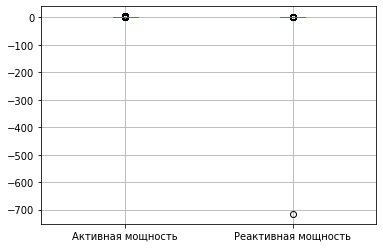

In [34]:
df_arc.drop('key', axis = 1).boxplot()

In [35]:
df_arc = df_arc.drop(df_arc[df_arc['Реактивная мощность']<-100].index)

<AxesSubplot:>

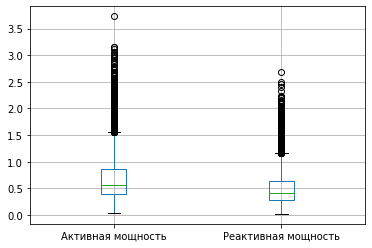

In [36]:
df_arc.drop('key', axis = 1).boxplot()

In [37]:
df_arc['Полная мощность'] = ((df_arc['Активная мощность'])**2 + (df_arc['Реактивная мощность'])**2)**(1/2)

In [38]:
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0.640648
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0.855559
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0.874560
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0.264489


потребление энергии будем считать по формуле Полная_мощность*время нагрева. Приведением единиц измерения заниматься не будем, тут это не важно, главное что единицы измерения одинаковы. нужно посчитать количество секунду нагрева

In [39]:
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'])
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'])

In [40]:
df_arc['Время нагрева'] = (df_arc['Конец нагрева дугой']) - (df_arc['Начало нагрева дугой'])

In [41]:
df_arc['Время нагрева'] = df_arc['Время нагрева'].dt.total_seconds()

In [42]:
df_arc['Время нагрева']

0        228.0
1        185.0
2        172.0
3        365.0
4        148.0
         ...  
14871    157.0
14872    180.0
14873    184.0
14874     57.0
14875     81.0
Name: Время нагрева, Length: 14875, dtype: float64

In [43]:
df_arc['Энергия'] = df_arc['Время нагрева']*df_arc['Полная мощность']

In [44]:
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева,Энергия
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228.0,272.149755
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185.0,177.416785
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172.0,154.118502
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365.0,719.221394
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148.0,119.471318
...,...,...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0.640648,157.0,100.581755
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0.855559,180.0,154.000682
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0.874560,184.0,160.919002
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0.264489,57.0,15.075853


#### Сводная таблица Нагрева

Итак, в сводной таблице нам нужно будет следующее - ключ, время начала первого нагрева, время конца последнего нагрева, суммарное время всех нагревов, суммарная затраченная энергия нагревов

In [45]:
df_arc_pivot  =pd.pivot_table(df_arc, values=['Начало нагрева дугой','Конец нагрева дугой','Время нагрева','Энергия'],
               index=['key'],
               aggfunc={
                   'Начало нагрева дугой':np.min,
                   'Конец нагрева дугой':np.max,
                   'Время нагрева':np.sum,
                   'Энергия':np.sum})

In [46]:
df_arc_pivot = df_arc_pivot.reset_index()

In [47]:
df_arc_pivot

,key,Время нагрева,Конец нагрева дугой,Начало нагрева дугой,Энергия
0,1,1098.0,2019-05-03 11:28:37,2019-05-03 11:02:14,1442.377754
1,2,811.0,2019-05-03 11:53:18,2019-05-03 11:34:14,881.233565
2,3,655.0,2019-05-03 12:32:19,2019-05-03 12:06:54,525.066777
3,4,741.0,2019-05-03 12:57:50,2019-05-03 12:39:37,796.911309
4,5,869.0,2019-05-03 13:33:55,2019-05-03 13:11:13,1199.137958
...,...,...,...,...,...
3209,3237,909.0,2019-08-31 23:03:48,2019-08-31 22:41:18,958.336236
3210,3238,546.0,2019-08-31 23:41:28,2019-08-31 23:26:18,555.867370
3211,3239,1216.0,2019-09-01 02:15:43,2019-09-01 01:26:53,1013.067719
3212,3240,839.0,2019-09-01 03:34:08,2019-09-01 02:35:24,729.208940


ну вот. так более пригодно

#### Сводная таблица температур

In [48]:
df_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0


теперь тут сводную сделаем

In [49]:
df_temp_pivot = pd.pivot_table(df_temp, values=['Время замера','Температура'],
               index=['key'],
               aggfunc={
                   'first','last'})

In [50]:
df_temp_pivot = df_temp_pivot.reset_index()

In [51]:
df_temp_pivot.columns = ['key' ,'Время замера first' , 'Время замера last','Температура first', 'Температура last' ]

In [52]:
df_temp_pivot

,key,Время замера first,Время замера last,Температура first,Температура last
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0
...,...,...,...,...,...
2467,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0
2468,2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0
2469,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0
2470,2498,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0,1594.0


теперь у нас все таблицы с ключом как уникальным идентификатором. таблицы можно объединять. но сначала избавимся от NAN и выбросов

#### Твердые присадки

In [53]:
df_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [54]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


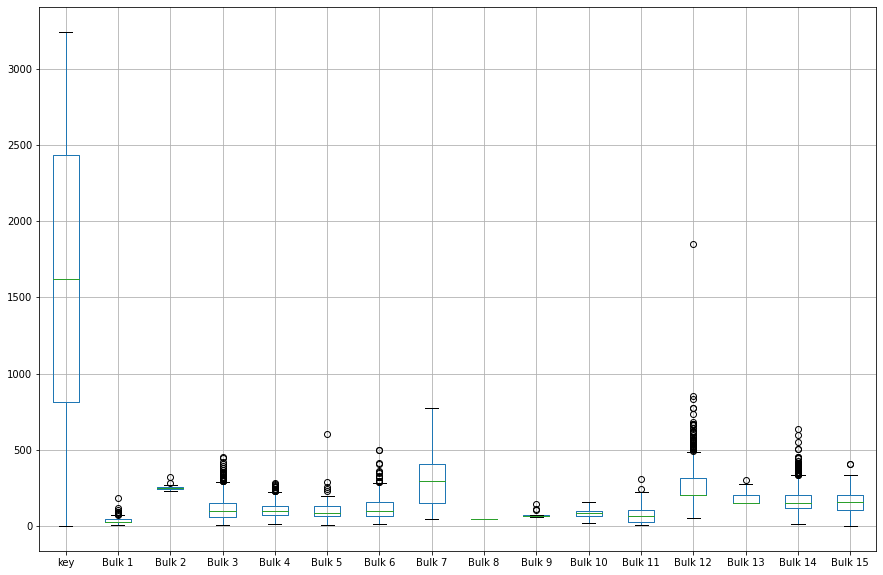

In [55]:
df_bulk.boxplot(figsize = (15,10));

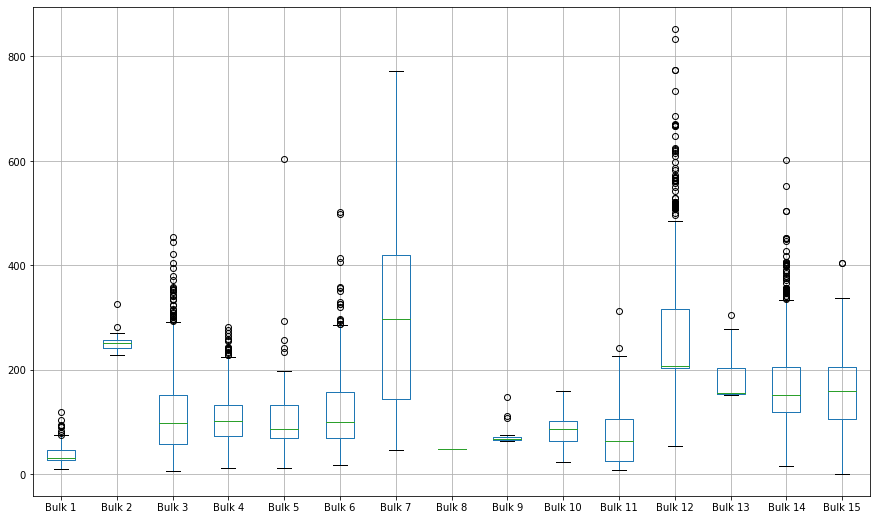

In [56]:
df_bulk = df_bulk.drop(df_bulk[df_bulk['Bulk 12']>1000].index)
df_bulk.drop('key', axis = 1).boxplot(figsize = (15,9));

#### проводные присадки

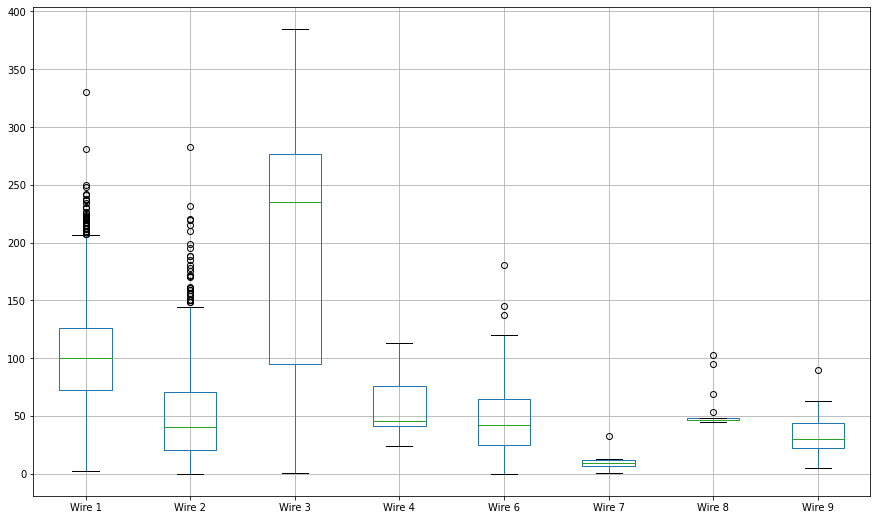

In [57]:
df_wire = df_wire.drop('Wire 5', axis = 1)
df_wire.drop('key', axis = 1).boxplot(figsize = (15,9));

тоже не вижу сильно выдающихся значений. то что методом boxplot отмечено как выбросы для одной операции укладывается в норму для другой.

Такой аспект лучше уточнять у того, кто в курсе технологии процесса

### Заполнение пропусков

#### Твердые присадки

In [58]:
df_bulk=df_bulk.fillna(0)

df_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


In [59]:
df_bulk_time = df_bulk_time.fillna('2019-05-03 00:00:00')
df_bulk_time.columns = df_bulk_time.columns.str.replace('Bulk','Bulk_time')
df_bulk_time.columns

Index(['key', 'Bulk_time 1', 'Bulk_time 2', 'Bulk_time 3', 'Bulk_time 4',
       'Bulk_time 5', 'Bulk_time 6', 'Bulk_time 7', 'Bulk_time 8',
       'Bulk_time 9', 'Bulk_time 10', 'Bulk_time 11', 'Bulk_time 12',
       'Bulk_time 13', 'Bulk_time 14', 'Bulk_time 15'],
      dtype='object')

#### Проволочные присадки

In [60]:
df_wire = df_wire.fillna(0)
df_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
df_wire_time =df_wire_time.fillna('2019-05-03 00:00:00')

df_wire_time.columns = df_wire_time.columns.str.replace('Wire','Wire_time')
df_wire_time

,key,Wire_time 1,Wire_time 2,Wire_time 3,Wire_time 4,Wire_time 5,Wire_time 6,Wire_time 7,Wire_time 8,Wire_time 9
0,1,2019-05-03 11:11:41,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00
1,2,2019-05-03 11:46:10,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00
2,3,2019-05-03 12:13:47,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00
3,4,2019-05-03 12:48:05,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00
3077,3238,2019-08-31 23:38:24,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00
3078,3239,2019-09-01 01:50:43,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00
3079,3240,2019-09-01 03:12:02,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00,2019-05-03 00:00:00


#### Газ

<AxesSubplot:>

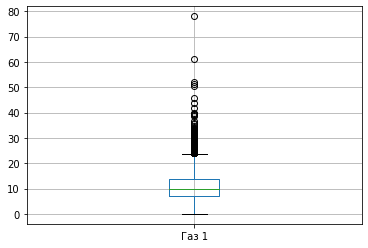

In [62]:
df_gas.drop('key', axis = 1).boxplot()

отрежем все что выше 40

<AxesSubplot:>

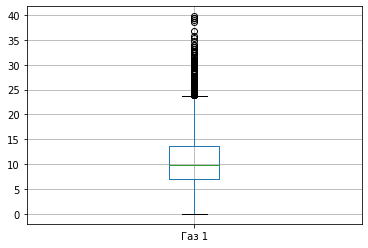

In [63]:
df_gas = df_gas.drop(df_gas[df_gas['Газ 1']>40].index)
df_gas.drop('key', axis = 1).boxplot()

### Общая сводная таблица

собираем таблицы, будем делать методом inner, чтобы остались только ключи о которых есть полная информация

In [64]:
df = df_temp_pivot.merge(df_arc_pivot, how = 'inner', on = 'key')
df = df.merge( df_gas, how = 'inner', on = 'key')
df = df.merge( df_bulk, how = 'inner', on = 'key')
#df = df.merge( df_bulk_time, how = 'inner', on = 'key')
df = df.merge( df_wire, how = 'inner', on = 'key')
#df = df.merge( df_wire_time, how = 'inner', on = 'key')
df

,key,Время замера first,Время замера last,Температура first,Температура last,Время нагрева,Конец нагрева дугой,Начало нагрева дугой,Энергия,Газ 1,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,1098.0,2019-05-03 11:28:37,2019-05-03 11:02:14,1442.377754,29.749986,...,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,811.0,2019-05-03 11:53:18,2019-05-03 11:34:14,881.233565,12.555561,...,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,655.0,2019-05-03 12:32:19,2019-05-03 12:06:54,525.066777,28.554793,...,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,741.0,2019-05-03 12:57:50,2019-05-03 12:39:37,796.911309,18.841219,...,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,869.0,2019-05-03 13:33:55,2019-05-03 13:11:13,1199.137958,5.413692,...,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2313,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0,723.0,2019-08-06 00:51:13,2019-08-06 00:31:05,778.818234,7.125735,...,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2314,2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0,940.0,2019-08-06 01:23:32,2019-08-06 01:00:06,875.261419,9.412616,...,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2315,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0,569.0,2019-08-06 01:50:45,2019-08-06 01:38:01,556.930349,6.271699,...,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0
2316,2498,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0,1594.0,750.0,2019-08-06 02:20:24,2019-08-06 01:57:46,767.817794,14.953657,...,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2318 entries, 0 to 2317
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   2318 non-null   int64         
 1   Время замера first    2318 non-null   object        
 2   Время замера last     2318 non-null   object        
 3   Температура first     2318 non-null   float64       
 4   Температура last      2318 non-null   float64       
 5   Время нагрева         2318 non-null   float64       
 6   Конец нагрева дугой   2318 non-null   datetime64[ns]
 7   Начало нагрева дугой  2318 non-null   datetime64[ns]
 8   Энергия               2318 non-null   float64       
 9   Газ 1                 2318 non-null   float64       
 10  Bulk 1                2318 non-null   float64       
 11  Bulk 2                2318 non-null   float64       
 12  Bulk 3                2318 non-null   float64       
 13  Bulk 4            

In [66]:
df.describe()

,key,Температура first,Температура last,Время нагрева,Энергия,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
count,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,...,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000
mean,1252.244176,1587.318378,1593.381795,805.508197,899.928861,11.252475,3.272649,1.068162,47.298533,37.207075,...,153.787748,120.257981,102.468853,17.544712,3.129712,0.243876,0.905186,0.005835,0.292943,0.318618
std,714.682882,23.549808,11.110834,335.603542,645.167426,5.941295,11.698295,16.261077,75.282204,58.676949,...,80.563530,84.599367,43.227215,33.474538,27.820783,4.209850,8.392751,0.204985,4.309765,3.464687
min,1.000000,1519.000000,1543.000000,57.000000,15.158096,0.008399,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,630.250000,1571.000000,1587.000000,581.000000,464.853195,7.271672,0.000000,0.000000,0.000000,0.000000,...,105.000000,0.000000,73.328577,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1255.500000,1587.000000,1593.000000,777.500000,767.593080,10.087796,0.000000,0.000000,0.000000,0.000000,...,149.000000,107.000000,101.103600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1867.750000,1603.000000,1598.000000,992.000000,1165.153981,14.169244,0.000000,0.000000,79.750000,77.000000,...,204.000000,204.000000,127.705495,23.102560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2499.000000,1660.000000,1653.000000,4189.000000,10630.980668,39.728826,94.000000,282.000000,454.000000,281.000000,...,450.000000,405.000000,330.314424,282.780152,385.008668,113.231044,180.454575,8.490040,102.762401,62.025600


### Проверка данных на нормальность

Метод Шапиро не работает с Датами и Объектами (в нашем случае теми же датами), так что применим выборочно к некоторым столбцам

In [67]:
columns = ['key','Температура first', 'Температура last', 'Время нагрева', 'Газ 1',
          'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10',
          'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15',
           'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'
          ]
for column in columns:
    print(column)
    print(shapiro(df[column]))

key
ShapiroResult(statistic=0.9568048715591431, pvalue=1.1216132818806814e-25)
Температура first
ShapiroResult(statistic=0.9975656867027283, pvalue=0.0011277325684204698)
Температура last
ShapiroResult(statistic=0.9607965350151062, pvalue=1.4716145952710741e-24)
Время нагрева
ShapiroResult(statistic=0.949674129486084, pvalue=1.7158202319183215e-27)
Газ 1
ShapiroResult(statistic=0.9245885014533997, pvalue=1.2931091727777807e-32)
Bulk 1
ShapiroResult(statistic=0.30974769592285156, pvalue=0.0)
Bulk 2
ShapiroResult(statistic=0.037815868854522705, pvalue=0.0)
Bulk 3
ShapiroResult(statistic=0.6927962303161621, pvalue=0.0)
Bulk 4
ShapiroResult(statistic=0.6850308179855347, pvalue=0.0)
Bulk 5
ShapiroResult(statistic=0.09170454740524292, pvalue=0.0)
Bulk 6
ShapiroResult(statistic=0.47224700450897217, pvalue=0.0)
Bulk 7
ShapiroResult(statistic=0.02955693006515503, pvalue=0.0)
Bulk 8
ShapiroResult(statistic=0.005848407745361328, pvalue=0.0)
Bulk 9
ShapiroResult(statistic=0.04191899299621582, pval

Тест Шапиро проверяет Гипотезу о нормальности данных. Судя по p-значению гипотеза почти нигде не подтвердилась. считаем данные ненормально распределенными


### проверка коллинеарности

получилось малоинформативно, так что перестанем тратить на это производительность))

In [68]:
df[columns].corr(method='spearman')

,key,Температура first,Температура last,Время нагрева,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
key,1.000000,-0.030566,-0.098197,-0.033140,-0.025117,-0.062122,-0.012584,0.031890,-0.020431,0.019302,...,-0.137150,0.024014,-0.015291,0.052614,-0.023551,0.021189,-0.049501,0.035308,-0.056445,0.022791
Температура first,-0.030566,1.000000,0.311435,-0.419992,0.029358,0.057847,0.100523,-0.111800,0.190972,0.034763,...,-0.157877,-0.061117,0.279184,-0.110752,0.019085,0.058230,0.014542,0.036909,-0.029418,-0.001014
Температура last,-0.098197,0.311435,1.000000,0.236184,0.042027,-0.046976,-0.000019,-0.040148,0.237236,-0.026365,...,0.060615,0.226843,0.299542,-0.239032,-0.034977,-0.011858,-0.012230,-0.050889,-0.014934,-0.031898
Время нагрева,-0.033140,-0.419992,0.236184,1.000000,0.373261,0.073551,0.017887,0.085236,-0.058464,0.040370,...,0.438953,0.300094,0.041795,0.021990,0.040039,0.022885,0.023698,0.026014,0.006717,-0.000783
Газ 1,-0.025117,0.029358,0.042027,0.373261,1.000000,0.142500,0.096601,0.058663,-0.013935,0.057448,...,0.297046,0.061813,0.157855,0.065376,0.119486,0.074475,0.049915,0.045630,0.084659,0.019063
Bulk 1,-0.062122,0.057847,-0.046976,0.073551,0.142500,1.000000,0.175680,-0.007307,0.045989,0.054789,...,0.184752,0.034183,0.064122,-0.045040,0.051351,0.124864,0.126932,0.097279,-0.021714,0.001052
Bulk 2,-0.012584,0.100523,-0.000019,0.017887,0.096601,0.175680,1.000000,-0.052624,0.047490,0.444637,...,-0.101444,-0.084203,-0.112288,-0.046680,0.466634,0.799651,0.489085,0.447600,-0.004748,-0.006733
Bulk 3,0.031890,-0.111800,-0.040148,0.085236,0.058663,-0.007307,-0.052624,1.000000,-0.384385,-0.031964,...,0.010597,-0.014506,0.031082,0.114231,0.003283,-0.052624,0.009832,-0.023494,0.027486,0.019206
Bulk 4,-0.020431,0.190972,0.237236,-0.058464,-0.013935,0.045989,0.047490,-0.384385,1.000000,0.010364,...,-0.121122,0.083721,0.346577,-0.311255,-0.013396,0.028691,-0.034513,0.037204,-0.012376,-0.066533
Bulk 5,0.019302,0.034763,-0.026365,0.040370,0.057448,0.054789,0.444637,-0.031964,0.010364,1.000000,...,-0.049272,-0.068040,-0.018575,0.042134,0.196128,0.353830,0.205167,0.199123,-0.010710,-0.015186


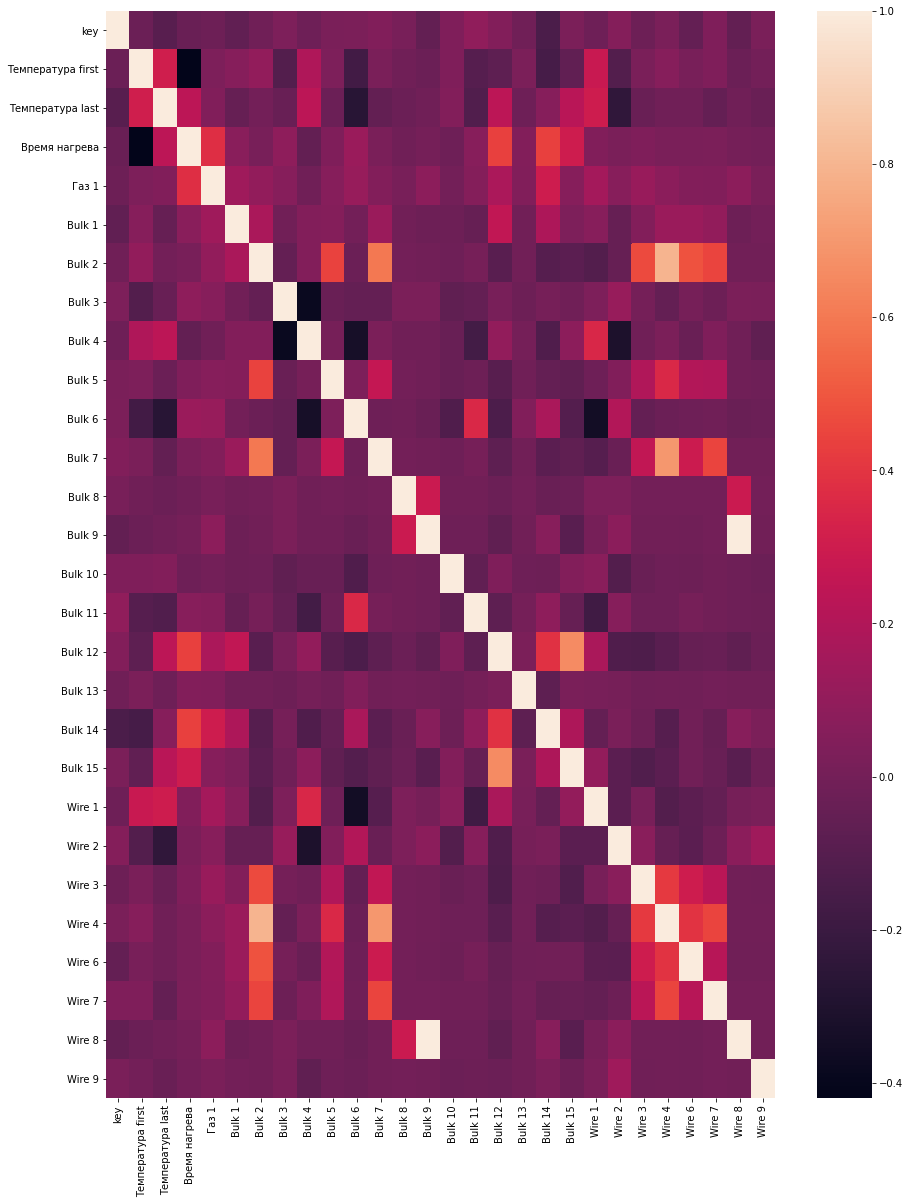

In [69]:
fig, ax = plt.subplots(figsize=(15,20))
sns.heatmap(df[columns].corr(method='spearman'));

по Хитмэпу есть зависимость только bulk 9 от wire 8, но и там и там всего по паре десятков значений. так что считаем что данные не зависят друг от друга

### Промежуточный вывод и Дальнейшие планы

Итак, мы ознакомились с данными, провели обработку,получили сводную таблицу и проверили коллинеарность данных.

Целевым признаком считаю температуру на которой остановили эксперимент, то есть Температура last

осталось определить все ли признаки использовать (есть куча столбцов с временем добавления присадок).

Прошу проверить и выдать рекомендации

линейная регрессия через крос.
лес и кэтбуст через грид серч

## Модели обучения

### подготовка данных

на данный момент нам более не нужны все исходные датафреймы и их можно удалить для освобождения оперативной памяти

In [70]:
del df_arc, df_bulk , df_bulk_time , df_gas, df_temp, df_wire, df_wire_time, df_arc_pivot, df_temp_pivot

избавимся от столбца Key, он помог нам свети таблицы, теперь он бесполезен.

In [71]:
df = df.drop('key', axis = 1)
df

,Время замера first,Время замера last,Температура first,Температура last,Время нагрева,Конец нагрева дугой,Начало нагрева дугой,Энергия,Газ 1,Bulk 1,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,1098.0,2019-05-03 11:28:37,2019-05-03 11:02:14,1442.377754,29.749986,0.0,...,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,811.0,2019-05-03 11:53:18,2019-05-03 11:34:14,881.233565,12.555561,0.0,...,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,655.0,2019-05-03 12:32:19,2019-05-03 12:06:54,525.066777,28.554793,0.0,...,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,741.0,2019-05-03 12:57:50,2019-05-03 12:39:37,796.911309,18.841219,0.0,...,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,869.0,2019-05-03 13:33:55,2019-05-03 13:11:13,1199.137958,5.413692,0.0,...,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2313,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0,723.0,2019-08-06 00:51:13,2019-08-06 00:31:05,778.818234,7.125735,0.0,...,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2314,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0,940.0,2019-08-06 01:23:32,2019-08-06 01:00:06,875.261419,9.412616,0.0,...,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2315,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0,569.0,2019-08-06 01:50:45,2019-08-06 01:38:01,556.930349,6.271699,0.0,...,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0
2316,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0,1594.0,750.0,2019-08-06 02:20:24,2019-08-06 01:57:46,767.817794,14.953657,0.0,...,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
df[df['Температура first']>df['Температура last']]['Энергия'].count()

870

In [73]:
df[df['Температура first']<df['Температура last']]['Энергия'].count()

1412

хм... интересное наблюдение. а я считал, что присадками как раз понижают температуру плавления.

преобразуем даты в понятные числа

In [74]:
df['Время замера first'] = pd.to_datetime(df['Время замера first'])
df['Время замера last'] = pd.to_datetime(df['Время замера last'])

In [75]:
df['Конец нагрева дугой'] = df['Конец нагрева дугой'].view('int64')//10**9
df['Начало нагрева дугой'] = df['Начало нагрева дугой'].view('int64')//10**9
df['Время замера first'] = df['Время замера first'].view('int64')//10**9
df['Время замера last'] = df['Время замера last'].view('int64')//10**9
#df[['Конец нагрева дугой', 'Начало нагрева дугой', 'Время замера first','Время замера last' ]] = df[['Конец нагрева дугой', 'Начало нагрева дугой', 'Время замера first','Время замера last' ]].view('int64')//10**9
df

,Время замера first,Время замера last,Температура first,Температура last,Время нагрева,Конец нагрева дугой,Начало нагрева дугой,Энергия,Газ 1,Bulk 1,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1556882178,1556883039,1571.0,1613.0,1098.0,1556882917,1556881334,1442.377754,29.749986,0.0,...,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,1556883447,1556884752,1581.0,1602.0,811.0,1556884398,1556883254,881.233565,12.555561,0.0,...,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,1556885597,1556886897,1596.0,1599.0,655.0,1556886739,1556885214,525.066777,28.554793,0.0,...,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,1556887977,1556888365,1601.0,1625.0,741.0,1556888270,1556887177,796.911309,18.841219,0.0,...,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,1556889799,1556890561,1576.0,1602.0,869.0,1556890435,1556889073,1199.137958,5.413692,0.0,...,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2313,1565051745,1565052882,1570.0,1591.0,723.0,1565052673,1565051465,778.818234,7.125735,0.0,...,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2314,1565053374,1565054992,1554.0,1591.0,940.0,1565054612,1565053206,875.261419,9.412616,0.0,...,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2315,1565055713,1565056430,1571.0,1589.0,569.0,1565056245,1565055481,556.930349,6.271699,0.0,...,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0
2316,1565057029,1565058331,1591.0,1594.0,750.0,1565058024,1565056666,767.817794,14.953657,0.0,...,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
df ['на замерах итого сек'] = df['Время замера last'] - df['Время замера first']
df ['на нагреве итого сек'] = df['Конец нагрева дугой'] - df['Начало нагрева дугой']
df = df.drop('Время замера last', axis = 1)
df = df.drop('Время замера first', axis = 1)
df = df.drop('Конец нагрева дугой', axis = 1)
df = df.drop('Начало нагрева дугой', axis = 1)
df


,Температура first,Температура last,Время нагрева,Энергия,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,на замерах итого сек,на нагреве итого сек
0,1571.0,1613.0,1098.0,1442.377754,29.749986,0.0,0.0,0.0,43.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,861,1583
1,1581.0,1602.0,811.0,881.233565,12.555561,0.0,0.0,0.0,73.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1305,1144
2,1596.0,1599.0,655.0,525.066777,28.554793,0.0,0.0,0.0,34.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1300,1525
3,1601.0,1625.0,741.0,796.911309,18.841219,0.0,0.0,0.0,81.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,388,1093
4,1576.0,1602.0,869.0,1199.137958,5.413692,0.0,0.0,0.0,78.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,762,1362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2313,1570.0,1591.0,723.0,778.818234,7.125735,0.0,0.0,21.0,0.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1137,1208
2314,1554.0,1591.0,940.0,875.261419,9.412616,0.0,0.0,0.0,63.0,0.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1618,1406
2315,1571.0,1589.0,569.0,556.930349,6.271699,0.0,0.0,0.0,85.0,0.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,717,764
2316,1591.0,1594.0,750.0,767.817794,14.953657,0.0,0.0,90.0,0.0,0.0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1302,1358


In [77]:
#df[['Время нагрева','на замерах итого сек', 'на нагреве итого сек']].sort_values(by=['Время нагрева']).plot(
#    x = 'Время нагрева', y = 'на замерах итого сек',kind = 'scatter',figsize = (15,10))
df[df['Время нагрева']>df['на нагреве итого сек']][['Время нагрева','на нагреве итого сек']]

,Время нагрева,на нагреве итого сек
46,126.0,126
218,127.0,127
481,241.0,241
506,125.0,125
863,61.0,61
1269,119.0,119
1886,243.0,243
1966,125.0,125


Проверил, нет ли где еще ошибки в данных

#### разделение на таргет и признаки, на тест и трэйн

In [78]:
target = df['Температура last']
feature =  df.drop('Температура last', axis =1)

In [79]:
f_train, f_test, t_train, t_test = train_test_split(feature, target, test_size=0.25, random_state=Global_random)

#### масштабируем признаки

In [80]:
scaler = StandardScaler()
f_train = scaler.fit_transform(f_train)
f_test = scaler.transform(f_test)

In [81]:
t_train

1498    1572.0
808     1601.0
1162    1589.0
84      1587.0
7       1598.0
         ...  
1657    1589.0
1998    1582.0
724     1609.0
803     1579.0
1373    1597.0
Name: Температура last, Length: 1738, dtype: float64

In [82]:
f_train

array([[-1.24822339, -0.58043085, -0.33572673, ..., -0.08873689,
        -0.79543565, -0.72834443],
       [-0.19032442,  0.3071282 ,  0.85708769, ..., -0.08873689,
        -0.12876744, -0.10603904],
       [-0.27495634, -0.24759621, -0.31796158, ..., -0.08873689,
        -0.07921778, -0.08452908],
       ...,
       [ 0.57136283,  0.9787945 ,  0.32081296, ..., -0.08873689,
         0.458321  ,  0.52220013],
       [ 0.14820325,  1.44356359,  0.92707244, ..., -0.08873689,
         1.1550193 ,  1.16749893],
       [ 1.03683838,  0.06724737, -0.51520222, ..., -0.08873689,
         0.56267559,  0.51626635]])

### Линейная регрессия путем Кроссвалидации

In [83]:

model = LinearRegression()

scores=cross_val_score(model, f_train , t_train, cv=5, scoring='neg_mean_absolute_error')
res = scores.mean()

print('средняя ошибка:', res)


средняя ошибка: -415761034507.12317


или я что-то не понимаю, или модель совсем не работает. проверим руками

In [84]:
print(scores)

[-2.07880517e+12 -5.82887641e+00 -5.90525756e+00 -5.62501011e+00
 -5.59211210e+00]


In [85]:
f_train2, f_test2, t_train2, t_test2 = train_test_split(f_train, t_train, test_size=0.25, random_state=Global_random)

In [86]:
Model_LR = LinearRegression()
Model_LR.fit(f_train2, t_train2)
preds = Model_LR.predict(f_test2)
pd.DataFrame(preds)

,0
0,1582.418823
1,1594.610474
2,1601.161377
3,1594.186523
4,1589.293579
...,...
430,1597.796875
431,1596.654419
432,1590.837036
433,1593.026001


In [87]:
mean_absolute_error(preds,t_test2 )

3932178574505.7876

мм.. странно. вроде выводы в предсказаниях порхоже на правду, а МАЕ такая гигантская.

In [88]:
temp = pd.DataFrame(preds)
temp.describe()

,0
count,4.350000e+02
mean,3.932179e+12
std,8.201209e+13
min,1.561290e+03
25%,1.588234e+03
50%,1.593040e+03
75%,1.598196e+03
max,1.710498e+15


<div class="alert alert-info" style="border-color: green; border-radius: 5px">
10.01.2023
    
неактуально, теперь есть слишком гигантская температура

In [89]:
temp[temp[0]>1700].index

Int64Index([402], dtype='int64')

In [90]:
f_test2[temp[temp[0]>1700].index]

array([[ 2.26400118,  0.19918183, -0.61325846,  3.07362148,  2.20142969,
        15.77372543, -0.62404255,  1.24107363,  5.99910691, -0.40733038,
        13.24185655,  0.        , -0.06619321, -0.23947313, -0.18526428,
        -1.34893142, -0.07662936, -1.9123863 , -1.40313668, -2.15777037,
        -0.52504787,  3.01138692, 20.30723262, 13.20932213, 41.67733197,
        -0.06331886, -0.08873689,  4.72484735,  4.39176774]])

пока признаем модель нерабочей

In [91]:
pd.DataFrame(f_train).astype('int64').describe()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
count,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,...,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000
mean,0.021864,0.025316,0.104143,0.096663,0.204833,0.068470,0.235903,0.262371,0.101266,0.236479,...,0.008631,0.236479,0.110472,0.061565,0.100115,0.023590,0.060414,0.081703,0.116226,0.102417
std,0.683370,0.723361,0.738820,0.709245,0.791099,0.951577,0.649733,0.588881,0.942863,0.733211,...,0.696595,0.696156,0.932614,0.965857,0.939316,0.983465,0.961749,0.945370,0.801022,0.792804
min,-2.000000,-2.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,10.000000,14.000000,4.000000,7.000000,15.000000,5.000000,3.000000,25.000000,6.000000,...,5.000000,6.000000,12.000000,25.000000,18.000000,41.000000,23.000000,18.000000,16.000000,15.000000


#### Вывод

Похоже нужно пересмотреть данные касательно выбросов

### Random Forest через Grid Search

In [92]:
%%time
parameters = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [1,2,3,4],
}
regr = RandomForestRegressor(random_state=Global_random)

rfr = GridSearchCV(regr, parameters, scoring = 'neg_mean_absolute_error')
rfr.fit(f_train, t_train)

CPU times: user 55.7 s, sys: 466 ms, total: 56.2 s
Wall time: 56.2 s


GridSearchCV(estimator=RandomForestRegressor(random_state=261222),
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [100, 150, 200, 250, 300]},
             scoring='neg_mean_absolute_error')

In [93]:
rfr.best_score_

-6.565037211632665

In [94]:
rfr.best_params_

{'max_depth': 4, 'n_estimators': 300}

Уложились в требуемое ТЗ. но это максимальные значения из диаппазона параметров. а что если попробовать больше?

In [95]:
%%time
parameters = {
    'n_estimators': [300, 350, 400],
    'max_depth': [4,5,6],
}
regr = RandomForestRegressor(random_state=Global_random)

rfr2 = GridSearchCV(regr, parameters, scoring = 'neg_mean_absolute_error')
rfr2.fit(f_train, t_train)

CPU times: user 1min 8s, sys: 392 ms, total: 1min 9s
Wall time: 1min 9s


GridSearchCV(estimator=RandomForestRegressor(random_state=261222),
             param_grid={'max_depth': [4, 5, 6],
                         'n_estimators': [300, 350, 400]},
             scoring='neg_mean_absolute_error')

In [96]:
rfr2.best_score_

-6.2391046684654246

In [97]:
rfr2.best_params_

{'max_depth': 6, 'n_estimators': 300}

Попытка 3

In [98]:
%%time
parameters = {
    'n_estimators': [ 250, 300, 350, 400],
    'max_depth': [6,7,8,9,10,11,12,13,14,15],
}
regr = RandomForestRegressor(random_state=Global_random)

rfr3 = GridSearchCV(regr, parameters, scoring = 'neg_mean_absolute_error')
rfr3.fit(f_train, t_train)

CPU times: user 7min 58s, sys: 1.77 s, total: 8min
Wall time: 8min


GridSearchCV(estimator=RandomForestRegressor(random_state=261222),
             param_grid={'max_depth': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                         'n_estimators': [250, 300, 350, 400]},
             scoring='neg_mean_absolute_error')

In [99]:
rfr3.best_score_

-5.990406560517135

In [100]:
rfr3.best_params_

{'max_depth': 15, 'n_estimators': 400}

#### Вывод

ниже 6, считаю тоже хорошим результатом

### Catboost regressor через Grid Search

In [101]:
%%time
param_grid = [
{'depth':[1,3,5,7], 'iterations': [100,500,1000,1500], 'verbose' : [False]}
]

catboost_reg = CatBoostRegressor()
grid_search = GridSearchCV(catboost_reg, param_grid, cv=5,
                          scoring='neg_mean_absolute_error')
 
grid_search.fit(f_train, t_train)

CPU times: user 2min 32s, sys: 4.62 s, total: 2min 37s
Wall time: 3min 20s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fd163185910>,
             param_grid=[{'depth': [1, 3, 5, 7],
                          'iterations': [100, 500, 1000, 1500],
                          'verbose': [False]}],
             scoring='neg_mean_absolute_error')

In [102]:
grid_search.best_score_

-5.68984747728976

In [103]:
grid_search.best_params_

{'depth': 7, 'iterations': 1000, 'verbose': False}

а теперь поточнее посмотрим

In [104]:
%%time
param_grid = [
{'depth':[6,7,8,9], 'iterations': [900,1000,1100], 'verbose' : [False]}
]

catboost_reg = CatBoostRegressor()
gs = GridSearchCV(catboost_reg, param_grid, cv=5,
                          scoring='neg_mean_absolute_error')
 
gs.fit(f_train, t_train)

CPU times: user 10min 30s, sys: 6.7 s, total: 10min 36s
Wall time: 11min 24s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fd163147580>,
             param_grid=[{'depth': [6, 7, 8, 9],
                          'iterations': [900, 1000, 1100],
                          'verbose': [False]}],
             scoring='neg_mean_absolute_error')

In [105]:
gs.best_score_

-5.68984747728976

In [106]:
gs.best_params_

{'depth': 7, 'iterations': 1000, 'verbose': False}

а результат тот же последняя попытка

### Результаты лучших

Лес

In [107]:
rfr3.best_score_

-5.990406560517135

Кэтбуст

In [108]:
gs.best_score_

-5.68984747728976

## проверка лучшей модели на тестовой выборке

Итак, лидер у нас Кэтбуст с параметрами глубины 5 и 500 итерациями

In [109]:
gs.score( f_test, t_test)

-5.481165063938096

## Вывод моделей обучения

Итак, мы получили можель, которая предсказывает конечную температуру основываясь на предполагаемых параметрах процесса (присадках, потраченной энергии на нагрев, ее продолжительности и прочем). при подготовке данных нужным образом можно использовать модель для предсказаний.

## Значимость признаков

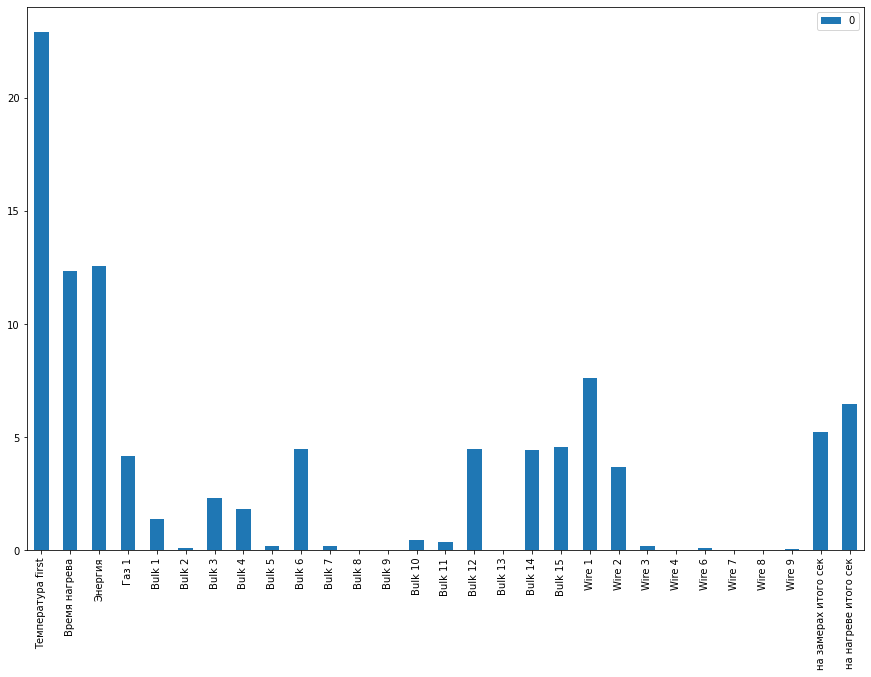

In [110]:
fetures_imp=pd.DataFrame(gs.best_estimator_.feature_importances_)
fetures_imp.index = feature.columns
fetures_imp.plot(kind = 'bar', figsize=(15,10));

### вывод

На графике Видно значимость каждого признака. остался вопрос - кого игнорировать. я бы рекомендовал "газ" и кто еще больше оставить



попробуем Lasso

In [111]:

Lreg = Lasso()

scores=cross_val_score(Lreg, f_train , t_train, cv=5, scoring='neg_mean_absolute_error')
res = scores.mean()

print('средняя ошибка:', res)


средняя ошибка: -6.485862095144938


а получилось приемлемо

# Отчет о проделанной работе

## Решаемая задача

Была поставлена задача на основе статистических данных разработать модель  машинного обучения, которая подзволит предсказать температуру розлива сплава на основе данных о процесее обработки

## Описание решения


- загружаем данные и знакомимся методами head , info и describe

при ознакомалении стало понятно, что таблицы имеют разную структуру и для объединения данных требуется обработка. для нас объектом изучения является ключ процесса, а соответственно таблицы измерения температуры и нагревов требуют обработки.

в таблице измерений температуры нас интересует температура на "финише". если в последнем этапе замер отсуствует, то такой ключь нас не интересует.

- чистим данные

убираем ненужные ключи, чистим от выбросов. преобразуем таблицы температуры и нагревов, собираем все в единую таблицу,
- заполняем пропуски

пропуски присутствуют только в таблицах присадок и продувки. считаем, что операции не проводились, поэтому заполняем Нулями

- собираем единую таблицу

объединяя по ключу процесса

- проверяем данные на нормальность распределения

данные оказались не нормального распределения

- проверка на мультиколлинеарность

используем метод Спирмена

- готовим данные для моделей обучения

разделяем данные на целевой признак и признаки обучения, разделяем на обучающую и тестовую выборки

- проверяем модели обучения методом кроссвалидации и подбора параметров через GridSearchCV

Linear Regression, Random Forest Regression, CatBoost Regressor




## Результат решения


оптимальной оказалась модель CatBoost Regressor со значением MAE в 5.68984747728976 на кросс валидации.

парметры при этом были определены такие:

'depth': 7, 'iterations': 1000

на тестовой выборке модель показала MAE в 5.68984747728976

значимость признаков можно наблюдать на графике:

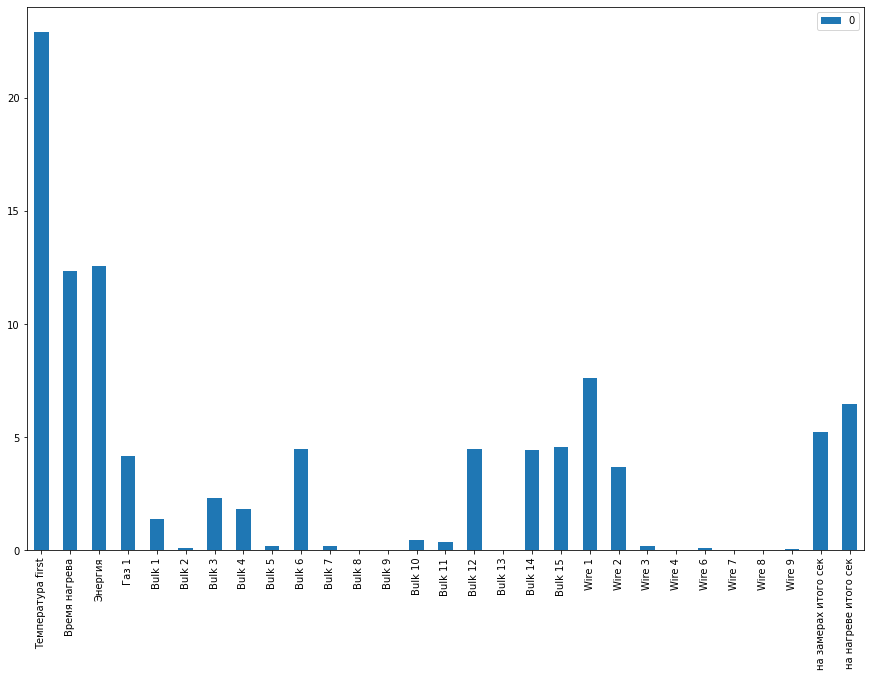

## Вопросы из задания

- Какие пункты плана были выполнены, а какие — нет (поясните почему)?

вроде все выполнил.

- Какие трудности возникли и как вы их преодолели?

Сделал для себя важный вывод - не бросаться резать данные при первой неудачной модели.

- Какие ключевые шаги в решении задачи выделили?

правильная подготовка данных - как переварить несколько строк таблицы, описывающих 1 ключ в одну строку. пожалуй в остальное было аналогично проектным работам в процессе обучения.

- Какая ваша итоговая модель и какое у неё качество?

Catboost regressor ('depth': 7, 'iterations': 1000)

mae = 5.68984747728976

переводя на человеческий - Модель способна предсказать конечную температуру процесса с средней абсолютной погрешностью в 5,68 Градуса Цельсия (Кельвина)